In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# $\phi^4$ Lattice Implementation with Hybrid Monte Carlo

This notebook intends to simulate the $\phi^4$ theory in two dimensions. Stefan Scheafer's Les Houches 2009 lectures were used as a reference. There is a module of a series of functions named lattice.py that is used to make this notebook readable. 

For our purposes, the action in $\phi^4$ theory can be generalized as follows. 
$$ S(\phi)= \sum_x \bigg[ -2\kappa \sum_{\mu=0} ^{D-1}\phi_x \phi_{x+\mu} + \phi_x^2+\lambda (\phi_x^2-1)^2 \bigg]$$ where $\phi$ is a real valued field that lives on the lattice sites, with each site $x$ having the scalar real value $\phi_x$. Our lattice is described in characteristic length $L$, dimension $D$ and lattice spacing of length a. For our case, we will work in $D=2$ dimensions and the lattice spacing will be $a=1$. Therefore, L will be the number of sites along one edge.

For this system, the partition function can be written as $$ Z=\int \prod_x d\phi_x exp(-S(\phi))=\int \prod_x d\pi_x \prod_x d\phi_x exp(-H(\pi,\phi))$$ where $\pi_x$ is the momentum and the Hamiltonian is defined as $H(\pi,\phi)=\frac{1}{2}\sum_x \pi_x^2+S(\phi)$.

Any observable $A(\phi)$ can be written as $$ \langle A \rangle=\frac{1}{Z}\int \prod_x d\phi_x exp(-S(\phi))A(\phi)$$

The observable that I will be paying attention to for this project is the magnetization per unit volume, $\langle m \rangle /V$, to find a critical $\kappa$ value. The magnetization $m$ is defined as $$ |m| = \frac{1}{V}|\sum_x \phi_x|$$

The Momentum Heat-Bath algorithm will be used for our purposes with a combination of Molecular Dynamics.

Another small detail is that the "hop" function in the lectures may easily be "hopped" and replaced with `np.roll()` or more simply, done manually as here. We will assume a periodic boundary condition.

The momentum $\pi$ and field $\phi$ evolution can be calculated through a molecular dynamics model. They obey the following:
$$ \frac{d}{d\tau}\phi_x(\tau)=\frac{\partial}{\partial\pi_x}H(\pi(\tau), \phi(\tau)) $$
$$ \frac{d}{d\tau}\pi_x(\tau)=-\frac{\partial}{\partial\phi_x}H(\pi(\tau), \phi(\tau)) $$

These differential equations can be implemented using Verlet method as follows:
$$ \nabla_{\phi_x} S (\phi)= -2\kappa J_x+2\phi_x+4\lambda (\phi_x^2-1)\phi_x$$
(I do think this particular expression has a missing sign in front of $\phi_x^2$, because otherwise I get runtime errors)
$$\nabla_{\pi_x}H_1(\pi)=\pi_x$$ where $H_1= \sum_x \pi^2_x/2$
In the paper, It's been defined that $J_x \equiv \sum^{D=1}_{\mu=0} (\phi_{x+\mu}+\phi_{x-\mu})$.
Additionally, we will have to have our $\phi$ and $\pi$ with each step as follows:
$$\phi \rightarrow \phi + \epsilon \nabla_\pi H_1(\pi) $$
$$\pi \rightarrow \pi - \epsilon \nabla S(\phi)$$ where $\epsilon$ is the MC time step.

https://nic.desy.de/sites2009/site_nic/content/e44192/e62778/e91179/e91180/hmc_tutorial_eng.pdf

In [130]:
def action(phi, kappa, lamb):
    """
    Args:
    - phi: the real, scalar field defined at each point of the lattice.
    - kappa, lamb: constants associated with the action
    
    Returns:
    - S: Action as defined in the notebook
    """
    
    action = np.sum(-2 * kappa * phi * (np.roll(phi, 1, axis=0) + np.roll(phi, 1, axis=1)) + (1 - 2 * lamb) * phi**2 + lamb * phi**4)
    return action


def Hamiltonian(pi, S):
    """
    Args:
    - phi: the real, scalar field defined at each point of the lattice.
    - pi: momenta at each point of the lattice.
    - kappa, lamb: constants associated with the action
    
    Returns:
    - H: Hamiltonan for the system
    """
    
    momentum = np.sum(pi**2)
    H = 0.5*momentum + S
    
    return H

def magnetization(phi):
    """
    Args:
    - phi: the real, scalar field defined at each point of the lattice.
    
    Returns:
    - mag: absolute magnetization expectation value of the lattice.
    """
    mag=np.sum(np.abs(phi))/(phi.shape[0]*phi.shape[1])
    return mag

def evolution(phi, kappa, lamb):
    "The derivative of the action which will be the evolution in momentum"
    field = (2*kappa*(np.roll(phi, 1, 0) + np.roll(phi, -1, 0) + np.roll(phi, 1, 1) + np.roll(phi, -1, 1)) 
             + 2*phi - 4*lamb*np.power(phi,3) + 4*phi*lamb)
    return field
#s[i,j]*(s[(i-1)%L,j]+s[(i+1)%L,j]+s[i,(j-1)%L]+s[i,(j+1)%L]

def HMC_step(phi,pi, S, kappa, lamb, time):
    
    """
    Each step of the Hybrid MC simulation.
    """
    
    N = len(time)
    dt = (time[1]-time[0])/N
    
    
    #Keep a copy of the current field phi[] in phiold[], I will do the same for piold.
    
    phiold = phi.copy()
    piold = pi.copy()
    
    #Measure the current value of the Hamiltonian Hi. 
    Hi = Hamiltonian(pi, S)
    
    #Molecular dynamics with initial values mom[] and phi[]. These fields get over- written by the values after the evolution.
    
    pi = pi + 0.5*dt * evolution(phi, kappa, lamb)
    phi = phi + dt * pi
    pi = pi + 0.5*dt * evolution(phi, kappa, lamb)
    
    S_new = action(phi, kappa, lamb)
    H_new = Hamiltonian(pi, S_new)

    if H_new < Hi:
        return phi, pi, S_new, H_new
    else:
        prob=np.exp(-Hi+H_new)
        if np.random.rand() < prob:
            return phi, pi, S_new, H_new
        else:
            return phiold, piold, S, Hi


def simulate_HMC(phi, S, kappa, lamb, time, Ns):
    pi = np.random.randn(phi.shape[0],phi.shape[1])
    actions=[]
    hamiltonians =[]
    for i in range(Ns):
        phi, pi, S, H = HMC_step(phi,pi, S, kappa, lamb, time)
        actions.append(S)
        hamiltonians.append(H)
    hamiltonians=np.array(hamiltonians)
    actions=np.array(actions)
    
    return phi, actions, hamiltonians

#I have gotten significant help from Julian Urban's github as some steps in the main paper seemed to have 
#sign errors and gave me Runtime warnings. 


## Testing the code 
In order to test the code, I will start with a uniform phi field of ones and run the simulation for $\kappa=0.2$. This should give me a non-uniform, almost random field as the heat bath will evolve in a coupled manner.


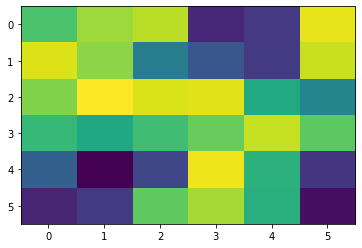

In [131]:
phi_ones = np.random.rand(6,6)
phi_test = []
S = action(phi_ones,0.2,1.1689)
phi_test,action_test, hamiltonian_test = simulate_HMC(phi_ones,S, 0.2, 1.1689, np.linspace(0,100,100), 10000)
plt.imshow(phi_test, aspect='auto')

I will also be testing that the action decreases as the simulation goes on to affirm the correctness of the code. I will take the same field above.

Text(0, 0.5, 'Hamiltonian')

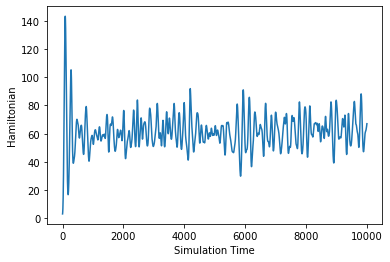

In [132]:
simulation_time=np.linspace(0,action_test.shape[0],action_test.shape[0])
plt.plot(simulation_time, hamiltonian_test)
plt.xlabel("Simulation Time")
plt.ylabel("Hamiltonian")

These two tests show that the simulation itself works as intended in a physical and computational sense.

## Physics Results
To test the physics of the code, we will use the Fig 2.5 as a reference. If the simulation works as intended, the result should give a clear value for a critical $\kappa$ value.

In [107]:
#Let's start with a random field phi
phi = np.random.randn(6,6)
kappas = np.linspace(0.15,0.22,11)
phis6 = []
for k in kappas:
    S = action(phi,k,1.1689)
    phi_6=simulate_HMC(phi,S, k, 1.1689, np.linspace(0,100,100), 2000)[0]
    phis6.append(phi_6)
print("6x6 Lattice done")
phi = np.random.randn(8,8)
phis8 = []
for k in kappas:
    S = action(phi,k,1.1689)
    phi_8=simulate_HMC(phi,S, k, 1.1689, np.linspace(0,100,100), 2000)[0]
    phis8.append(phi_8)
print("8x8 Lattice done")
phi = np.random.randn(10,10)
phis10 = []
for k in kappas:
    S = action(phi,k,1.1689)
    phi_10=simulate_HMC(phi, S, k, 1.1689, np.linspace(0,100,100), 2000)[0]
    phis10.append(phi_10)
print("10x10 Lattice done")
phi = np.random.randn(12,12)
phis12 = []
for k in kappas:
    S = action(phi,k,1.1689)
    phi_12=simulate_HMC(phi,S, k, 1.1689, np.linspace(0,100,100), 2000)[0]
    phis12.append(phi_12)
print("12x12 Lattice done")

6x6 Lattice done
8x8 Lattice done
10x10 Lattice done
12x12 Lattice done


In [108]:
phis6=np.array(phis6)
phis8=np.array(phis8)
phis10=np.array(phis10)
phis12=np.array(phis12)
magnetizations6=np.array([magnetization(phi) for phi in phis6])
magnetizations8=np.array([magnetization(phi) for phi in phis8])
magnetizations10=np.array([magnetization(phi) for phi in phis10])
magnetizations12=np.array([magnetization(phi) for phi in phis12])

Text(0, 0.5, 'Magnetization per volume')

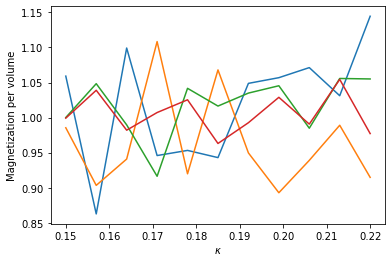

In [109]:
plt.plot(kappas, np.array(magnetizations6), label="L=6")
plt.plot(kappas, np.array(magnetizations8), label="L=8")
plt.plot(kappas, np.array(magnetizations10), label="L=10")
plt.plot(kappas, np.array(magnetizations12), label="L=12")
plt.xlabel("$\kappa$")
plt.ylabel("Magnetization per volume")

This plot is intended to show the critical $\kappa$ value in $\frac{\langle |m| \rangle}{V}$. However, my code unfortunately does not work, which is quite frustrating. The fact that everything else works properly makes me think that the problem is the definition of $\langle |m| \rangle$ in my code. However, I cannot seem to find a reasonable way to implement it.